In [1]:
%matplotlib nbagg
import gym
import math
import random
import collections
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fcnl

In [2]:
class Agent:
    eps_decay = 100
    eps_start = 0.9
    eps_end = 0.0

    class DQN(nn.Module):
        hidden_units = 64

        def __init__(self, env):
            super().__init__()
            self.fc1 = nn.Linear(env.observation_space.shape[0], self.hidden_units)
            self.fc2 = nn.Linear(self.hidden_units, env.action_space.n)

        def forward(self, x):
            x = fcnl.tanh(self.fc1(x))
            x = self.fc2(x)
            return x

    def __init__(self, env):
        self.env = env
        self.eps = self.eps_start
        self.policy_net = self.DQN(env)
        self.target_net = self.DQN(env)
        self.target_net.eval()

    def __call__(self, state):
        episode = len(self.env.stats_recorder.episode_lengths)
        exploration_decay = math.exp(-episode / self.eps_decay)
        self.eps = self.eps_end + (self.eps_start - self.eps_end) * exploration_decay

        if random.random() > self.eps:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32)
                action_values = self.policy_net(state)
                return int(action_values.argmax())
        else:
            return self.env.action_space.sample()


In [3]:
class ReplayMemory(list):
    Transition = collections.namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

    def __init__(self, capacity):
        super().__init__()
        self.capacity = capacity
        self.position = 0

    def push(self, *args):
        if len(self) < self.capacity:
            self.append(None)
        self[self.position] = self.Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self, batch_size)


In [4]:
class ReplayOptimizer(optim.Adam):
    gamma = 0.9
    update_interval = 10

    def __init__(self, agent, memory, **kwargs):
        super().__init__(agent.policy_net.parameters(), **kwargs)
        self.agent = agent
        self.memory = memory
        self.batch_size = int(0.10 * memory.capacity)
        self.loss = torch.tensor(0.0)

    def step(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = ReplayMemory.Transition(*zip(*transitions))

        states = torch.tensor(batch.state, dtype=torch.float32)
        actions = torch.tensor(batch.action)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32)
        rewards = torch.tensor(batch.reward, dtype=torch.float32)
        done_mask = torch.tensor([done for done in batch.done])

        state_values = self.agent.policy_net(states)
        state_action_values = state_values.gather(dim=1, index=actions[:, None]).squeeze()

        with torch.no_grad():
            next_state_values = self.agent.target_net(next_states)
            next_state_values[done_mask] = 0
            target_state_action_values = rewards + (self.gamma * next_state_values.max(dim=1)[0])

        self.loss = fcnl.mse_loss(state_action_values, target_state_action_values)
        self.zero_grad()
        self.loss.backward()
        super().step()

        if len(self.agent.env.stats_recorder.episode_lengths) % self.update_interval == 0:
            policy_net_state = agent.policy_net.state_dict()
            agent.target_net.load_state_dict(policy_net_state)


In [5]:
class TrainingMonitor:
    def __init__(self, env, agent, optimizer):
        self.env = env
        self.agent = agent
        self.optimizer = optimizer
        self.rewards = env.stats_recorder.episode_rewards
        self.mean_rewards = []
        self.losses = []
        self.figure, self.axes = plt.subplots(2, 1)

        self.axes[0].set_title('Training Monitor')
        self.axes[0].set_ylabel('Reward')
        self.axes[0].plot([], [], 'go', label='Episode Reward')
        self.axes[0].plot([], [], 'g', label='Mean Reward (50)')

        self.axes[1].set_ylabel('Training Loss')
        self.axes[1].set_xlabel('Episode ')
        self.axes[1].plot([], [], label='Training Loss')

    def plot(self):
        self.episodes = range(len(self.rewards))
        self.mean_rewards.append(sum(self.rewards[-50:])/50)
        self.losses.append(float(self.optimizer.loss))

        self.axes[0].lines[0].set_xdata(self.episodes)
        self.axes[0].lines[0].set_ydata(self.rewards)
        self.axes[0].lines[1].set_xdata(self.episodes)
        self.axes[0].lines[1].set_ydata(self.mean_rewards)
        self.axes[0].relim()
        self.axes[0].autoscale_view()

        self.axes[1].lines[0].set_xdata(self.episodes)
        self.axes[1].lines[0].set_ydata(self.losses)
        self.axes[1].relim()
        self.axes[1].autoscale_view()

        self.figure.canvas.draw()
        plt.pause(0.001)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


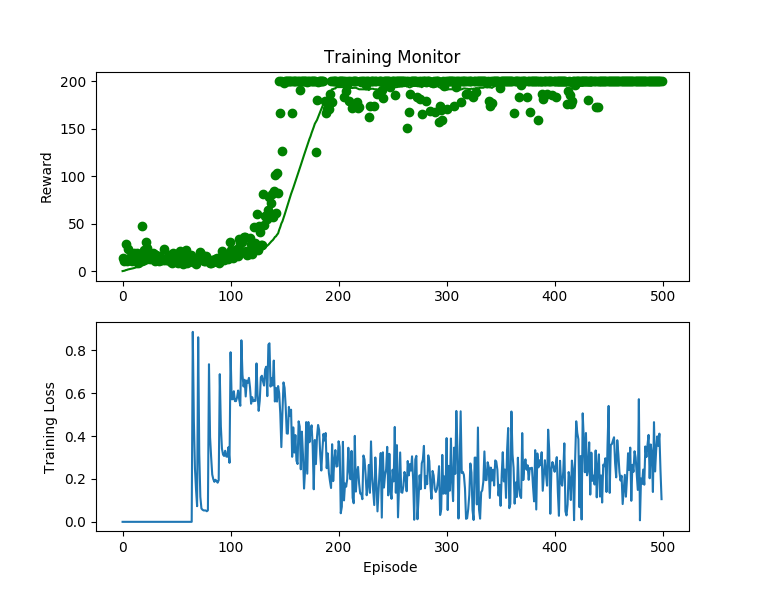

In [6]:
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, directory='monitor', force=True)

agent = Agent(env)
memory = ReplayMemory(10_000)
optimizer = ReplayOptimizer(agent, memory)
monitor = TrainingMonitor(env, agent, optimizer)

for episode in range(500):
    state, done = env.reset(), False
    while not done:
        action = agent(state)
        new_state, reward, done, _ = env.step(action)
        memory.push(state, action, new_state, reward, done)
        state = new_state
        optimizer.step()
    monitor.plot()
